In [2]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob


In [4]:
from skimage import feature
import mahotas

ImportError: cannot import name '_validate_lengths'

In [169]:
kernel = np.ones((11,11),np.uint8)

In [14]:
# Reading Origine Images
image_list = []
image_name = []
labels_= []
path = 'Skin_lesion_DB/Training/mel/Orig/*.jpg'
for filename in glob.glob(path):
    im=mpimg.imread(filename,)
    image_name.append(filename[9:])
    #im =cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel)
    #im = cv2.cvtColor(im, cv2.COLOR_RGB)
    #ret,im = cv2.threshold(im,127,255,cv2.THRESH_TRUNC)
    image_list.append(im)
    labels_.append(1)
path2 = 'Skin_lesion_DB/Training/nonmel/Orig/*.jpg'
for filename in glob.glob(path2):
    im=mpimg.imread(filename)
    image_name.append(filename[9:])
    #im =cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel)
    #im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    #ret,im = cv2.threshold(im,127,255,cv2.THRESH_TRUNC)
    image_list.append(im)
    labels_.append(0)
#plt.imshow(image_list[1])
#plt.show()

In [15]:
# Reading Contour Images
contour_list = []
contour_name = []
path = 'Skin_lesion_DB/Training/mel/Contour/*.png'
for filename in glob.glob(path):
    im=mpimg.imread(filename)
    contour_name.append(filename[9:])
    #im=cv2.cvtColor(im,cv2.COLOR_GRAY2RGB)
    contour_list.append(im)
    labels_.append(1)
path2 = 'Skin_lesion_DB/Training/nonmel/Contour/*.png'
for filename in glob.glob(path2):
    im=mpimg.imread(filename)
    contour_name.append(filename[9:])
    #im=cv2.cvtColor(im,cv2.COLOR_GRAY2RGB)
    contour_list.append(im)
    labels_.append(0)

    

#plt.imshow(contour_list[0])
#plt.show()

In [16]:
#for i,j in zip(image_list,contour_list):
#    bit_and = cv2.bitwise_and(i, j)
#    im_cnt.append(bit_and)

def Segmentation(orig, cont):
    r = orig[:,:,0]
    g = orig[:,:,1]
    b = orig[:,:,2]
    rc = np.multiply(r, cont)
    gc = np.multiply(g, cont)
    bc = np.multiply(b, cont)
    return np.dstack((rc,gc,bc)).astype(np.uint8)

image_segmented = [Segmentation(orig, cont) for orig,cont in zip(image_list, contour_list)]


In [17]:
def colorFeature(im):
    R = im[:,:,0]
    G = im[:,:,1]
    B = im[:,:,2]
    rs = cv2.cvtColor(im, cv2.COLOR_BGR2YCrCb)
    return [np.mean(R), np.std(R), np.mean(G), np.std(G), np.mean(B), np.std(B), np.mean(rs), np.std(rs)]
print(colorFeature(image_list[1]))

[178.0029902329076, 16.57171306786541, 136.85360380666165, 23.34859761160305, 124.60647132481843, 24.324612598289026, 135.68217881292261, 18.916921141198102]


In [18]:
def hsvHistFeature(im):
    img = cv2.cvtColor(im, cv2.COLOR_RGB2HLS)
    h = cv2.calcHist([img],[0],None,[8],[0, 8]) / np.max(img[:,:,0])
    s = cv2.calcHist([img],[1],None,[2],[0, 2]) / np.max(img[:,:,1])
    v = cv2.calcHist([img],[2],None,[2],[0, 2]) / np.max(img[:,:,2])
    return np.concatenate((h, s, v), axis=None)
    
res = hsvHistFeature(image_list[1])
print(res)

[9.4333334e+00 1.8472221e+01 3.6988888e+01 3.9155556e+01 7.6972221e+01
 1.3475555e+02 1.1786667e+02 1.4730556e+02 0.0000000e+00 0.0000000e+00
 3.9215689e-03 0.0000000e+00]


In [19]:
def textureFeature(im):
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    glcm = feature.greycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
    stats = feature.greycoprops(glcm, prop='contrast')
    return stats

res = textureFeature(image_list[1])
print(res)

[[126.05580896 202.99691554 122.7125565  147.12830963]]


In [20]:
def fd_hu_moments(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(im)).flatten()
    return feature

print(fd_hu_moments(image_list[1]))

[ 1.36876380e-03  2.91736532e-07  9.97273763e-13  3.99473035e-13
 -2.40609031e-25  1.15241247e-16  7.53717044e-26]


In [21]:
def fd_haralick(im):
    # convert the image to grayscale
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick
print(fd_haralick(image_list[1]))

[ 1.03926715e-03  1.49723398e+02  8.51497491e-01  5.04372598e+02
  2.45388096e-01  2.75491750e+02  1.86776699e+03  7.40037293e+00
  1.11800094e+01  3.65654723e-04  4.02317211e+00 -2.64343620e-01
  9.81933662e-01]


In [61]:
def createFeatures(db):
    features = []
    for im in db:
        im_c = colorFeature(im)
        hsvHf = hsvHistFeature(im)
        tx = textureFeature(im)
        hu_f= fd_hu_moments(im)
        har_f=fd_haralick(im)
        features.append(np.concatenate((im_c,hsvHf,hu_f,tx,har_f), axis=None))
    return features

features = createFeatures(image_list)
print(np.shape(features))

(58, 44)


In [62]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=2).fit(features)
print(kmeans.labels_)

[0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1 1
 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0]


In [84]:
from sklearn.preprocessing import LabelEncoder
# encode the target labels

targetNames = np.unique(labels_)
le = LabelEncoder()
target = le.fit_transform(labels_)
print("[STATUS] training labels encoded...")

[STATUS] training labels encoded...


In [85]:
from sklearn.preprocessing import MinMaxScaler
# normalize the feature vector in the range (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(features)
print("[STATUS] feature vector normalized...")

[STATUS] feature vector normalized...


In [86]:
import h5py
print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

# save the feature vector using HDF5
h5f_data = h5py.File('data.h5', 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File('labels.h5', 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

print("[STATUS] end of training..")

[STATUS] target labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]
[STATUS] target labels shape: (116,)
[STATUS] end of training..


In [87]:
#Testiiiing

In [88]:
# import the necessary packages
import h5py
import numpy as np
import os
import glob
import cv2
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib


# no.of.trees for Random Forests
num_trees = 100

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=9)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=9)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=9)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=9)))

# variables to hold the results and names
results = []
names = []
scoring = "accuracy"


In [89]:
# import the feature vector and trained labels
h5f_data = h5py.File('data.h5', 'r')
h5f_label = h5py.File('labels.h5', 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")

[STATUS] features shape: (58, 44)
[STATUS] labels shape: (116,)
[STATUS] training started...


In [90]:
# train_test_split size
test_size = 0.10

# seed for reproducing same results
seed = 9
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))

ValueError: Found input variables with inconsistent numbers of samples: [58, 116]


LR: 0.943333 (0.124766)
LDA: 0.753333 (0.186905)
KNN: 0.923333 (0.130000)
CART: 1.000000 (0.000000)
RF: 0.983333 (0.050000)
NB: 0.903333 (0.097125)
SVM: 0.710000 (0.211896)


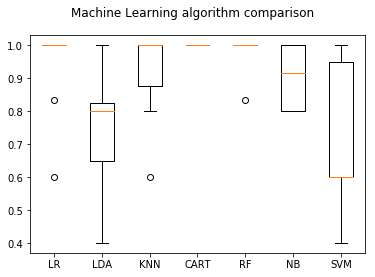

Wall time: 1.63 s


In [91]:
%%time
# filter all the warnings
import warnings
warnings.filterwarnings('ignore')

# 10-fold cross validation
print("")
for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [92]:

# create the model - Random Forests
clf  = RandomForestClassifier(n_estimators=100, random_state=9)
# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=9, verbose=0, warm_start=False)

In [93]:
image_list_test = []
image_name_test = []
path_test = 'Skin_lesion_DB/Test/Orig/*.jpg'
for filename in glob.glob(path_test):
    im=mpimg.imread(filename)
    image_name_test.append(filename[9:])
    image_list_test.append(im)


In [94]:
features_test = createFeatures(image_list_test)
print(np.shape(features_test))

(11, 44)


In [95]:
prediction = clf.predict(features_test)

In [96]:
print(prediction)

[1 1 1 1 1 1 1 1 1 1 1]


In [97]:
# importing the accuracy measuring function 
from sklearn.metrics import accuracy_score 
  
# evaluating the accuracy 
print(accuracy_score(image_name_test, prediction)) 

0.0


In [98]:
clf_b = GaussianNB()
clf_b.fit(trainDataGlobal, trainLabelsGlobal)

GaussianNB(priors=None, var_smoothing=1e-09)

In [99]:
prediction_b = clf_b.predict(features_test)

# show predicted label on image
#cv2.putText(im, image_name_test[prediction_b], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

# display the output image
#plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
#plt.show()

In [100]:
print(prediction_b)

[1 1 1 1 1 1 1 1 1 1 1]


In [101]:
print(accuracy_score(image_name_test, prediction_b)) 

0.0
